# Подготовка к работе с Colab

In [0]:
!pip install jcamp

  Created wheel for jcamp: filename=jcamp-1.2.1-py2.py3-none-any.whl size=8332 sha256=0db2de84ebc529b1f65960cd0d05ab42e3b343b5ccd353cbef7d5fcb278d2f55
  Stored in directory: /root/.cache/pip/wheels/e5/48/bf/58e53110ec2c7cac7089a90d51b2d53ebff2cf3c068e209bda
Successfully built jcamp


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import jcamp
from IPython.display import display
from pylab import rcParams # для установления размера картинок

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls '/content/drive/My Drive/Colab Notebooks/components/'

Acetone.jdx  Butane.jdx  CO.jdx      Formaldehyde.jdx  Propane.jdx
Benzene.jdx  CO2.jdx	 Ethane.jdx  NO.jdx	       Toluene.jdx


# Задание 1

Прочитаем имена всех файлов из директории `'components'`

In [0]:
directory = '/content/drive/My Drive/Colab Notebooks/components/'
file_names = os.listdir(directory)
file_names.sort()
file_names

['Acetone.jdx',
 'Benzene.jdx',
 'Butane.jdx',
 'CO.jdx',
 'CO2.jdx',
 'Ethane.jdx',
 'Formaldehyde.jdx',
 'NO.jdx',
 'Propane.jdx',
 'Toluene.jdx']

In [0]:
for file_name in file_names:
    spec = jcamp.JCAMP_reader(directory + file_name)
    print('{:15s} {:15s} {:15s}'.format(spec['title'], spec['yunits'], spec['xunits']))

Acetone         ABSORBANCE      1/CM           
Benzene         ABSORBANCE      1/CM           
Butane          ABSORBANCE      1/CM           
Carbon monoxide ABSORBANCE      1/CM           
Carbon dioxide  ABSORBANCE      1/CM           
Ethane          ABSORBANCE      1/CM           
FORMALDEHYDE    TRANSMITTANCE   1/CM           
NITRIC OXIDE    TRANSMITTANCE   MICROMETERS    
Propane         ABSORBANCE      1/CM           
Toluene         ABSORBANCE      1/CM           


Сформируем базу данных в виде словаря `DB` из всех спектров в директории `'components'`

In [0]:
DB = {'title':[], 'I':[], 'k':[]}

for file_name in file_names:
    sub = jcamp.JCAMP_reader(directory + file_name)

    # приведение всех интенсивностей спектров к TRANSMITTANCE
    if sub['yunits'] == 'TRANSMITTANCE':
      inten = sub['y']
    elif sub['yunits'] == 'ABSORBANCE':
      inten = np.exp(-sub['y'])

    # приведение всех сеток к волновым числам k [1/CM]
    #k = sub['x'] - не правильная сетка из jcamp
    k = np.arange(sub['firstx'], sub['lastx']+sub['deltax'], sub['deltax'])
    if sub['xunits'] == '1/CM':
      pass      
    elif sub['xunits'] == 'MICROMETERS':
      k = 1 / k * 10 ** 4
      k, inten = k[::-1], inten[::-1]
    
    # заплатка для FORMALDEHYDE
    if sub['title'] == 'FORMALDEHYDE':
      k = sub['x']
      
    # запись спектра в базу данных
    DB['title'].append( sub['title'] )
    DB['I'].append( inten )
    DB['k'].append( k )

Выведем графики полученных спектров:

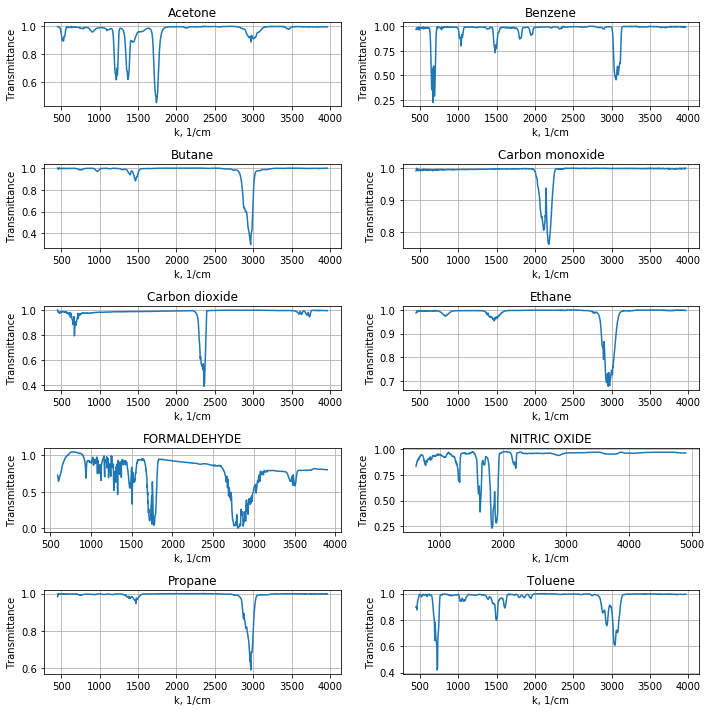

In [0]:
def plot_DB(DB):
  rcParams['figure.figsize'] = 10, 10
  for i in range(len(DB['I'])):
    plt.subplot(5,2,i+1)
    plt.plot(DB['k'][i], DB['I'][i], label = DB['title'][i])
    plt.title(DB['title'][i])
    plt.ylabel('Transmittance')
    plt.xlabel('k, 1/cm')
    plt.grid()
  plt.tight_layout()
  plt.show()
plot_DB(DB)

Информация о сетке волновых чисел для каждого вещества

In [0]:
def get_info(data_base):
  info = {'Name':[], 'dk':[], 'k_min':[], 'k_max':[], 'len(k)':[], 'I_max':[], 'I_min':[]}
  for i in range(len(DB['I'])):
    info['Name'].append( DB['title'][i] )
    info['I_max'].append( max(DB['I'][i]) )
    info['I_min'].append( min(DB['I'][i]) )
    info['dk'].append( DB['k'][i][1] - DB['k'][i][0] )
    info['k_min'].append( DB['k'][i][0] )
    info['k_max'].append( DB['k'][i][-1] )
    info['len(k)'].append( len(DB['k'][i]) )
  df = pd.DataFrame(info)
  display(df)

get_info(DB)  

,Name,dk,k_min,k_max,len(k),I_max,I_min
0,Acetone,4.000000,450.000000,3966.000000,880,1.000,0.455395
1,Benzene,4.000000,450.000000,3966.000000,880,1.000,0.223895
2,Butane,4.000000,450.000000,3966.000000,880,1.000,0.299111
3,Carbon monoxide,4.000000,450.000000,3966.000000,880,1.000,0.761809
4,Carbon dioxide,4.000000,450.000000,3966.000000,880,1.000,0.392861
5,Ethane,4.000000,450.000000,3966.000000,880,1.000,0.678969
6,FORMALDEHYDE,1.159198,587.635000,3902.941411,3576,1.050,0.002200
7,NITRIC OXIDE,0.259775,625.681758,4901.960784,2103,0.975,0.233000
8,Propane,4.000000,450.000000,3966.000000,880,1.000,0.589754
9,Toluene,4.000000,450.000000,3966.000000,880,1.000,0.420055


Нормируем и преобразуем интенсивности таким образом, чтобы глубина наиболее интенсивной линии составляла значение не более
80%:

In [0]:
for i in range(len(DB['I'])):
  # обрезка интенсивностей,которые больше 1
  DB['I'][i][ DB['I'][i]>1 ] = 1

  # преобразование глубины интенсивностей
  y_min = np.min(DB['I'][i])
  if y_min <= 0.2:
    resc_parametr = 0.8 / (1 - y_min)
    DB['I'][i] = (DB['I'][i] -1 )*resc_parametr + 1

Приведем все спектры к единой волновой сетке:

In [0]:
k_min = 630
k_max = 3902
dk = 4.0
k_uni = np.arange(k_min, k_max+dk, dk)
inten_uni = np.zeros(len(k_uni))

def lin_inter(xk, x1, x2, y1, y2):
  return (y1*(x2-xk) + y2*(xk-x1)) / (x2 - x1)


for i in range(len(DB['I'])):
  k_old = DB['k'][i]
  inten_old = DB['I'][i]
  
  for k_idx, k in enumerate(k_uni):
    for j in range(1, len(k_old)):
      if k >= k_old[j-1] and k < k_old[j]:
        inten_uni[k_idx] = lin_inter(k, k_old[j-1], k_old[j], inten_old[j-1], inten_old[j])
  DB['I'][i] = np.array(inten_uni)
  DB['k'][i] = np.array(k_uni)
  # правильней было бы записать k_uni один раз, но не хотелось переписывать get_info(DB)

Проверим информацию о новой единой сетке волновых чисел для каждого вещества:

In [0]:
get_info(DB)

,Name,dk,k_min,k_max,len(k),I_max,I_min
0,Acetone,4.0,630.0,3902.0,819,1.000000,0.455395
1,Benzene,4.0,630.0,3902.0,819,1.000000,0.223895
2,Butane,4.0,630.0,3902.0,819,1.000000,0.299111
3,Carbon monoxide,4.0,630.0,3902.0,819,1.000000,0.761809
4,Carbon dioxide,4.0,630.0,3902.0,819,0.997947,0.392861
5,Ethane,4.0,630.0,3902.0,819,1.000000,0.678969
6,FORMALDEHYDE,4.0,630.0,3902.0,819,1.000000,0.200565
7,NITRIC OXIDE,4.0,630.0,3902.0,819,0.975000,0.233280
8,Propane,4.0,630.0,3902.0,819,1.000000,0.589754
9,Toluene,4.0,630.0,3902.0,819,1.000000,0.420055


Выведем графики полученных спектров:

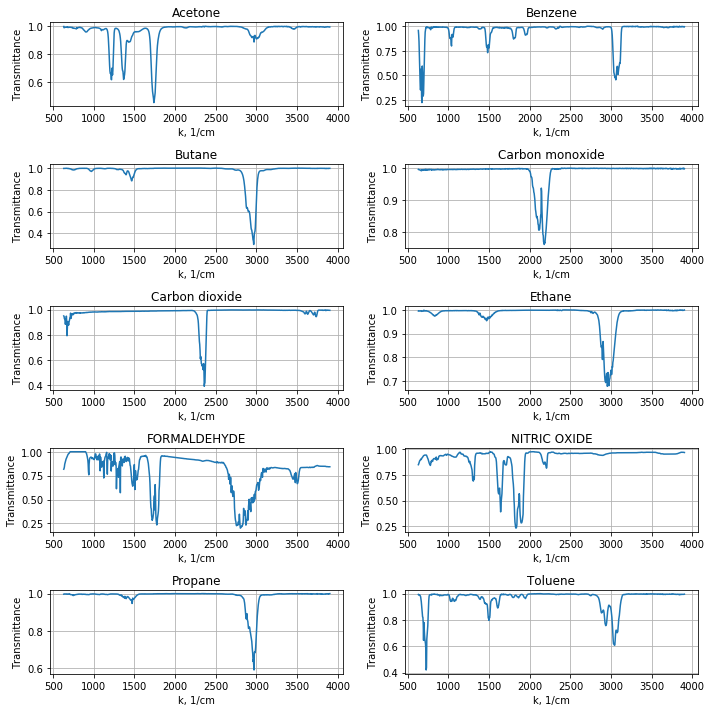

In [0]:
plot_DB(DB)

Построим матрицы кросс-корреляций Пирсона для нескольких интервалов спектров:

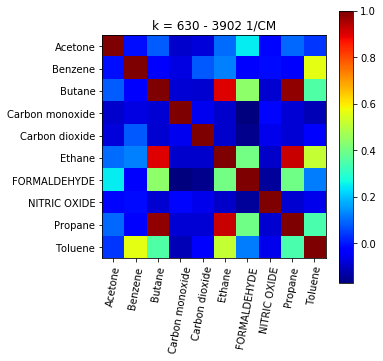

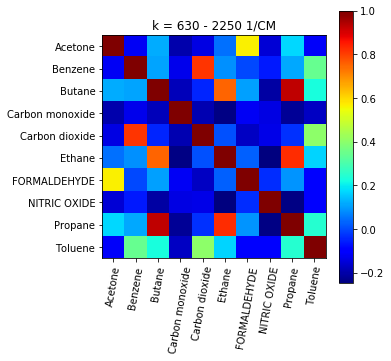

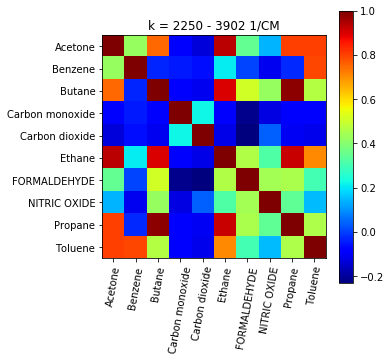

In [0]:
rcParams['figure.figsize'] = 5, 5

def draw_corr(data_base, lim):
  df = pd.DataFrame()
  for i in range(len(DB['I'])):
    df[DB['title'][i]] = DB['I'][i][ (DB['k'][i]>=lim[0]) & (DB['k'][i]<=lim[1]) ]
  
  plt.imshow(df.corr(), cmap='jet')
  plt.title('k = ' + str(lim[0]) + ' - ' + str(lim[1]) + ' 1/CM')
  plt.yticks(ticks = np.arange(0,len(df.columns),1), labels = df.columns)
  plt.xticks(rotation=80)
  plt.xticks(ticks = np.arange(0,len(df.columns),1), labels = df.columns)
  plt.colorbar()
  plt.show()

draw_corr(DB, [k_min, k_max])
draw_corr(DB, [630, 2250])
draw_corr(DB, [2250, 3902])

# Задание 2
Для одного из веществ с концентрацией 0.1 г/м2 построим спектр поглощения:

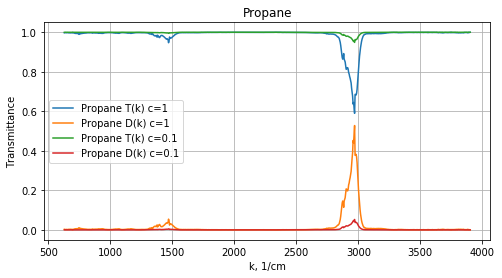

In [0]:
n_sub = 8 # нумерация не соответствует таблице 1 задания
c = 0.1
D = - np.log(DB['I'][n_sub]) * c
T = DB['I'][n_sub] ** c
k = DB['k'][n_sub]
title = DB['title'][n_sub]

rcParams['figure.figsize'] = 8, 4
plt.title(DB['title'][n_sub])
plt.plot(k, DB['I'][n_sub], label = title+' T(k) c=1')
plt.plot(k, -np.log(DB['I'][n_sub]), label = title+' D(k) c=1')
plt.plot(k, T, label = title+' T(k) c='+str(c))
plt.plot(k, D, label = title+' D(k) c='+str(c))
plt.ylabel('Transmittance')
plt.xlabel('k, 1/cm')
plt.grid()
plt.legend()
plt.show()


Смоделируем спектр пропускания с SNR = 1..5 с шагом 0.5:

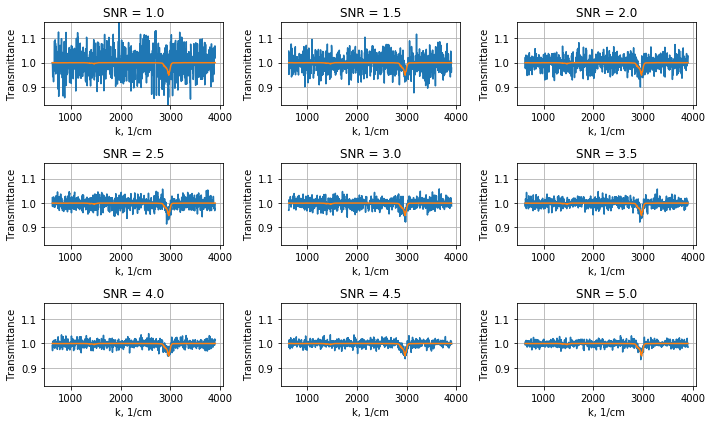

In [0]:
np.random.seed(9) # можно менять, если не нравится результат восстановления концентрации

SNR = np.arange(1, 5+0.5, 0.5)
noisy_T = np.zeros( (len(SNR), len(T)) )

for i in range(len(SNR)):
  noisy_T[i] = T + np.random.normal(loc=0, scale = (1-min(T))/SNR[i], size=len(T))

rcParams['figure.figsize'] = 10, 6
for i in range(len(SNR)):
  plt.subplot(3,3,i+1)
  plt.plot(k, noisy_T[i])
  plt.plot(k, T)
  plt.title('SNR = '+str(SNR[i]))
  plt.ylim((np.min(noisy_T), np.max(noisy_T)))
  plt.ylabel('Transmittance')
  plt.xlabel('k, 1/cm')
  plt.grid()
plt.tight_layout()
plt.show()

Идентифицируем вещество и определим его концентрацию с помощью метода наименьших квадратов в матричном виде:

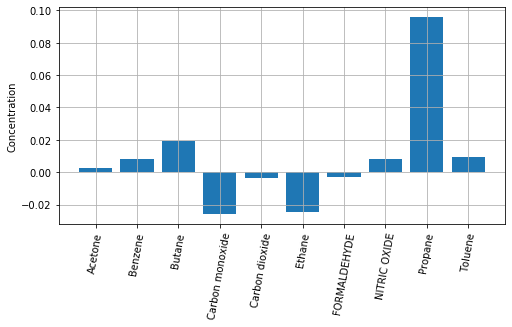

In [0]:
def MNK(T, DB_I): 
  D, DB_D = -np.log(T), -np.log(np.array(DB_I).T) # спектры в БД должны быть столбцами
  C = np.linalg.inv(DB_D.T @ DB_D) @ DB_D.T @ D
  return C

C = MNK(noisy_T[2], DB['I'])

rcParams['figure.figsize'] = 8, 4
plt.bar(DB['title'], C )
plt.ylabel('Concentration')
plt.xticks(rotation=80)
plt.grid()
plt.show()

Определим относительную погрешность восстановления концентрации:

In [0]:
print('Относительная погрешность восстановления концентрации =', np.abs(C[n_sub]-c)/c*100, '%')

Относительная погрешность воcстановления концентрации = 3.9029882826824567 %


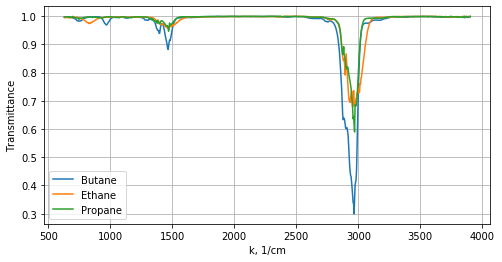

In [0]:
rcParams['figure.figsize'] = 8, 4

# Спектры бутана, этана, пропана похожи
for i in [2,5,8]:
  plt.plot(DB['k'][i], DB['I'][i], label = DB['title'][i])
  plt.ylabel('Transmittance')
  plt.xlabel('k, 1/cm')
  plt.grid()
  plt.legend()
plt.show()

# Задание 3

Смоделируем спектр смеси трех веществ с концентрациями 0.1, 0.15, 0.2:

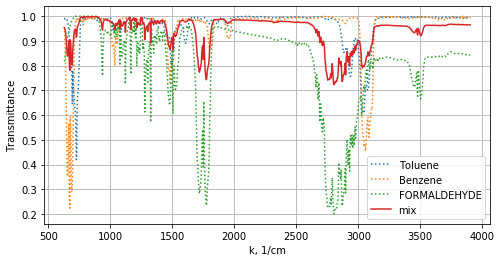

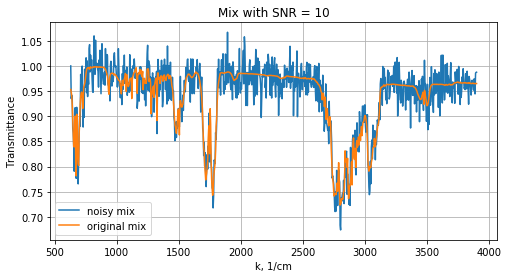

In [0]:
n_sub = [9, 1, 6] # нумерация не соответствует таблице 1 задания
c = np.zeros((len(DB['I'])))
c[n_sub] = np.array([0.1, 0.15, 0.2])
SNR = 10
np.random.seed(7) # можно менять, если не нравится результат восстановления концентрации

# составим спектр смеси
'''
D_mix = np.zeros(len(DB['I'][0]))
for i in n_sub:
  D_mix -= np.log( DB['I'][i] * c[i])
T_mix = np.exp(-D_mix)
'''
T_mix = np.ones(len(DB['I'][0]))
for i in n_sub:
  T_mix *= DB['I'][i] ** c[i]

# пошумим
noisy_T_mix = T_mix + np.random.normal(loc=0, scale = (1-min(T_mix))/SNR, size=len(T))

rcParams['figure.figsize'] = 8, 4
for i in n_sub:
  plt.plot(k, DB['I'][i], label = DB['title'][i], linestyle='dotted')
plt.plot(k, T_mix, label = 'mix')
plt.ylabel('Transmittance')
plt.xlabel('k, 1/cm')
plt.grid()
plt.legend()
plt.show()

plt.title('Mix with SNR = ' + str(SNR))
plt.plot(k, noisy_T_mix, label = 'noisy mix')
plt.plot(k, T_mix, label = 'original mix')
plt.ylabel('Transmittance')
plt.xlabel('k, 1/cm')
plt.grid()
plt.legend()
plt.show()

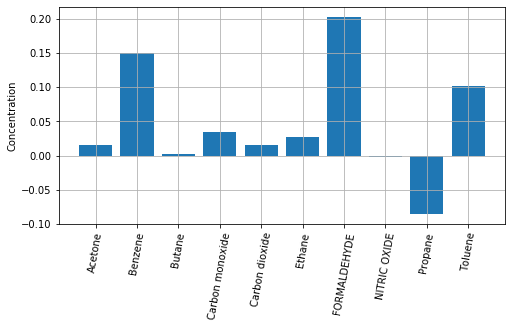

In [0]:
C = MNK(noisy_T_mix, DB['I'])

rcParams['figure.figsize'] = 8, 4
plt.bar(DB['title'], C )
plt.xticks(rotation=80)
plt.ylabel('Concentration')
plt.grid()
plt.show()

In [0]:
print('Относительная погрешность восстановления концентрации')
for i in n_sub:
  print('для {:15s} {:15f} %'.format(DB['title'][i], np.abs(C[i]-c[i])/c[i]*100))

Относительная погрешность воостановления концентрации
для Toluene                1.716741 %
для Benzene                0.066173 %
для FORMALDEHYDE           1.391509 %


# Задание 4

Реализуем идентификатор вещества по корреляции Пирсона:

In [0]:
def Pearson_identification(T, DB_I):
    DB_I = np.array(DB_I).T # транспонируем, тк спектры в БД должны быть столбцами
    T, DB_I = T-np.mean(T), DB_I-np.mean(DB_I, axis=0)
    r = np.dot(T, DB_I) / ( np.sqrt(np.sum(T**2) * np.sum(DB_I**2, axis=0)) )
    index_pred = np.argmax(r)
    r_max = r[index_pred]
    return (r_max, index_pred)

def SAM_identification(T, DB_I):
    DB_I = np.array(DB_I).T # транспонируем, тк спектры в БД должны быть столбцами
    cos = (np.dot(T, DB_I) / (np.sqrt( np.sum(T**2) * np.sum(DB_I**2, axis=0) )))
    index_pred = np.argmax(cos)
    cos_max = cos[index_pred]
    return (cos_max, index_pred)

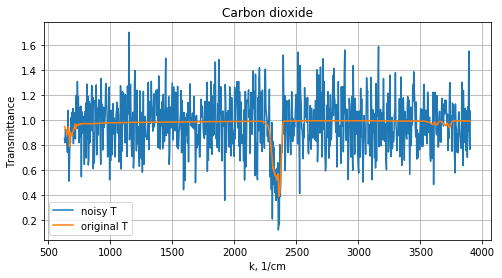

(0.3536324608034427, 4)

In [0]:
n_sub = 4 # нумерация не соответствует таблице 1 задания
SNR = 3
T = DB['I'][n_sub]
noisy_T = T + np.random.normal(loc=0, scale = (1-min(T))/SNR, size=len(T))

plt.plot(k, noisy_T, label='noisy T')
plt.plot(k, T, label='original T')
plt.title(DB['title'][n_sub])
plt.ylabel('Transmittance')
plt.xlabel('k, 1/cm')
plt.legend()
plt.grid()
plt.show()

Pearson_identification(noisy_T, DB['I'])

Рассмотрим вероятности правильного обнаружения вещества при различных порогах отсечки:

In [0]:
n_sub = 4 # нумерация не соответствует таблице 1 задания
SNR = 3
T = DB['I'][n_sub]

iterations = 1000
thresholds = np.arange(0.2, 0.5, 0.01)
TPR = []
for threshold in thresholds:
  TP = 0
  for i in range(iterations):
    noisy_T = T + np.random.normal(loc=0, scale = (1-min(T))/SNR, size=len(T))
    r, idx = Pearson_identification(noisy_T, DB['I'])
    if r >= threshold and idx == n_sub:
      TP += 1
  TPR.append( TP/iterations )

Определим порог отсечки при котором TPR >= 0.5:

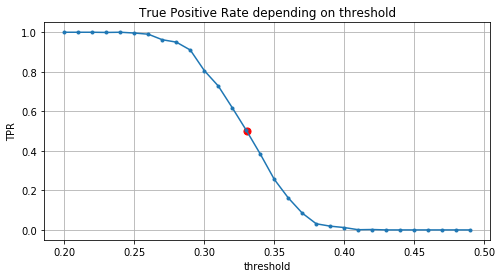

Порог отсечки, при котором TPR >= 0.5, равен 0.33033


In [0]:
TPR = np.array(TPR)
x1 = thresholds[len(TPR[TPR>0.5])-1]
x2 = thresholds[len(TPR[TPR>0.5])]
y1 = TPR[len(TPR[TPR>0.5])-1]
y2 = TPR[len(TPR[TPR>0.5])]
x_05 = lin_inter(0.5, y1, y2, x1, x2)

rcParams['figure.figsize'] = 8, 4
plt.title('True Positive Rate depending on threshold')
plt.plot(thresholds, TPR, marker='.')
plt.scatter(x_05, 0.5, s=50, color='red')
plt.ylabel('TPR')
plt.xlabel('threshold')
plt.grid()
plt.show()

print('Порог отсечки, при котором TPR >= 0.5, равен', round(x_05,5))

# Задание 5

Реализуем идентификатор вещества по углу между базовым и целевым спектром:

In [0]:
def Pearson_cor(T, DB_I, n_sub):
    DB_I = np.array(DB_I[n_sub])
    T, DB_I = T-np.mean(T), DB_I-np.mean(DB_I)
    r = np.dot(T, DB_I) / ( np.sqrt(np.sum(T**2) * np.sum(DB_I**2)) )
    return r

def SAM_cor(T, DB_I, n_sub):
    DB_I = np.array(DB_I[n_sub])
    cos = np.dot(T, DB_I) / (np.sqrt( np.sum(T**2) * np.sum(DB_I**2) ))
    return cos

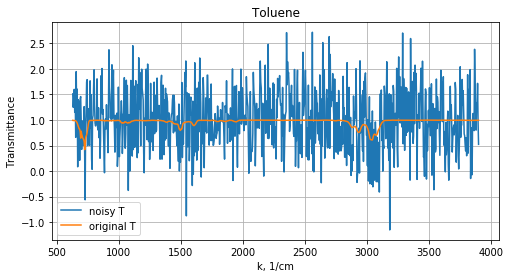

(0.8653041669206268, 9)

In [0]:
n_sub = 9 # нумерация не соответствует таблице 1 задания
SNR = 1
T = DB['I'][n_sub]
noisy_T = T + np.random.normal(loc=0, scale = (1-min(T))/SNR, size=len(T))

plt.plot(k, noisy_T, label='noisy T')
plt.plot(k, T, label='original T')
plt.title(DB['title'][n_sub])
plt.ylabel('Transmittance')
plt.xlabel('k, 1/cm')
plt.legend()
plt.grid()
plt.show()

SAM_identification(noisy_T, DB['I'])

Проведем ROC-анализ:

In [0]:
n_sub = 9 # нумерация не соответствует таблице 1 задания
SNR = 1
np.random.seed(42)

iterations = 2000
thresholds = np.arange(0.0, 0.5, 0.01)
FPR, TPR = [], []

for threshold in thresholds:
  TP, TN, FP, FN = 0, 0, 0, 0
  for i in range(iterations):
    rand_sub = random.randint(0, len(DB['I'])-1)
    #if i%2==0: rand_sub = n_sub  # каждое второе вещество это таргет
    T = DB['I'][rand_sub]
    noisy_T = T + np.random.normal(loc=0, scale = (1-min(T))/SNR, size=len(T))
    cos = Pearson_cor(noisy_T, DB['I'], n_sub)
    
    if cos > threshold:
      if n_sub == rand_sub: TP += 1
      if n_sub != rand_sub: FP += 1
    if cos <= threshold:
      if n_sub == rand_sub: FN += 1
      if n_sub != rand_sub: TN += 1

  FPR.append( FP/(TN+FP) )
  TPR.append( TP/(TP+FN) )

rcParams['figure.figsize'] = 5, 5
plt.title('ROC (receiver operating characteristic)')
plt.plot(FPR, TPR, marker='.')
plt.plot([0,1],[0,1])
plt.xlim((-0.1,1.1))
plt.ylim((-0.1,1.1))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid()
plt.show()

In [0]:
AUC = 0
for i in range(len(TPR)-1):
  AUC += (TPR[i]+TPR[i+1])/2 * (FPR[i]-FPR[i+1])
print('AUC =', AUC)

AUC = 0.978543150823162


In [0]:
TPR, FPR = np.array(TPR), np.array(FPR)
best_idx = np.argmin( (1-TPR)**2+FPR**2 )
print('Оптимальный порог отсечки =', round(thresholds[best_idx],5))
print('Оптимальный FPR =', round(FPR[best_idx],5))
print('Оптимальный TPR =', round(TPR[best_idx],5))

Оптимальный порог отсечки = 0.85
Оптимальный FPR = 0.15371
Оптимальный TPR = 0.9698


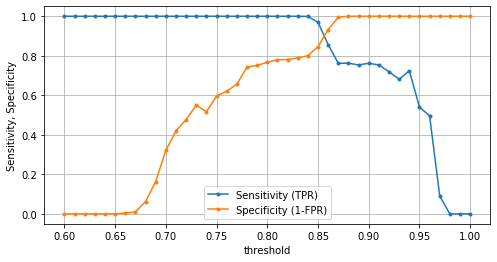

In [0]:
rcParams['figure.figsize'] = 8, 4
plt.plot(thresholds, TPR, label='Sensitivity (TPR)', marker='.')
plt.plot(thresholds, 1-np.array(FPR), label='Specificity (1-FPR)', marker='.')
plt.xlabel('threshold')
plt.ylabel('Sensitivity, Specificity')
plt.legend()
plt.grid()
plt.show()